This notebook plots the initial evolution of biases in 3 runs: a no-ML baseline, a fine-only prognostic run and a n2f prognostic run.

At most vertical levels and latitudes, both the fine-only and n2f prognostic runs have smaller temperature and humidity drifts than the baseline run. In general the n2f drifts are slightly smaller compare to fine-only, e.g. for temperature in the free troposphere (levels 25-60) or specific humidity in the boundary layer.

In [1]:
import numpy as np
import xarray as xr
import fsspec
import matplotlib.pyplot as plt
import vcm
from vcm.catalog import catalog
from vcm.fv3.metadata import gfdl_to_standard
import datetime
from datetime import timedelta
import string
import cftime
import yaml
from dask.distributed import Client
from scipy.interpolate import interp1d
plt.rcParams['figure.dpi'] = 150
xr.set_options(keep_attrs=True)

In [2]:
Client()

/home/OliWM/miniconda3/envs/fv3net/lib/python3.8/site-packages/distributed/dashboard/core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==2.2.3.
Continuing without the dashboard.
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 29.39 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39947,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 29.39 GiB
Comm: tcp://127.0.0.1:45585,Total threads: 2
Dashboard: http://127.0.0.1:36717/status,Memory: 7.35 GiB
Nanny: tcp://127.0.0.1:32873,


In [3]:
with open('run_urls.yaml') as f:
    runs = yaml.safe_load(f)

In [4]:
urls = {
    "baseline": runs['baseline-10day']['url'],
    "ML-physics": runs['prog-10day-seed5']['url'],
    "nudge-to-fine": runs['n2f-35day']['url'],
}
verif_url = 'gs://vcm-ml-experiments/default/2021-12-16/2020-05-27-40-day-X-SHiELD-simulation-v2/fine-res-budget.zarr'

In [5]:
INIT_TIME = cftime.DatetimeJulian(2016, 8, 5)

In [6]:
with open('ak.txt') as f:
    ak = list(map(float, f))
with open('bk.txt') as f:
    bk = list(map(float, f))

# reference pressure levels in hPa assuming 1000hPa surface pressure
plev = np.array(ak)/100 + np.array(bk) * 1000  
plev_mid = 0.5 * (plev[:-1] + plev[1:])

f = interp1d(plev_mid, range(0, 79), fill_value='extrapolate')
tick_labels = [3, 100, 300, 500, 700, 850, 1000]
tick_indices = f(tick_labels)

In [7]:
grid = catalog['grid/c48'].to_dask().load()

In [8]:
def open_zarr(url):
    return xr.open_zarr(fsspec.get_mapper(url))

In [9]:
ds = []
for name, url in urls.items():
    tmp = open_zarr(url + '/state_after_timestep.zarr')
    ds.append(tmp.assign_coords(run=name))
ds = xr.concat(ds, dim='run', join='inner')

In [10]:
verif = open_zarr(verif_url)
verif = gfdl_to_standard(verif).drop('tile')
verif['time'] = verif.time + datetime.timedelta(minutes=7, seconds=30)
verif = verif.rename(
    T='air_temperature', sphum='specific_humidity', delp='pressure_thickness_of_atmospheric_layer',
    LHTFLsfc_coarse='latent_heat_flux', SHTFLsfc_coarse='sensible_heat_flux'
)

In [11]:
variables = ['air_temperature', 'specific_humidity', 'pressure_thickness_of_atmospheric_layer', 'sensible_heat_flux', 'latent_heat_flux']

In [12]:
ds_all = xr.concat([ds[variables], verif[variables].assign_coords(run='verif')], dim='run', join='inner')

In [13]:
global_mean = vcm.weighted_average(ds_all, grid.area).compute()

In [14]:
tropical_ascent_mean = vcm.weighted_average(ds_all, grid.area.where(grid.lat>5).where(grid.lat<20)).compute()

In [15]:
error = global_mean - global_mean.sel(run='verif')
error = error.isel(run=slice(3))
error = xr.concat([xr.zeros_like(error.isel(time=0)).assign_coords(time=INIT_TIME), error], dim='time')
error['time'] = (error.time - error.time[0]).values / np.timedelta64(1, 'h')
error.time.attrs['units'] = 'hours elapsed'

In [16]:
ta_error = tropical_ascent_mean - tropical_ascent_mean.sel(run='verif')
ta_error = ta_error.isel(run=slice(3))
ta_error = xr.concat([xr.zeros_like(ta_error.isel(time=0)).assign_coords(time=INIT_TIME), ta_error], dim='time')
ta_error['time'] = (ta_error.time - ta_error.time[0]).values / np.timedelta64(1, 'h')
ta_error.time.attrs['units'] = 'hours elapsed'

### Plot global mean error as function of model level and time
Showing first 3 days of simulations

In [17]:
def plot_three_panel(da, set_xticks=True, use_reference_pressure=True, **kwargs):
    fg = da.plot(y='z', yincrease=False, col='run', **kwargs)
    fg.fig.set_size_inches((10, 2.7))
    fg.set_titles(template='{value}')
    if set_xticks:
        for ax in fg.axes.flat:
            ax.set_xticks(range(0, 241, 48))
    if use_reference_pressure:
        for i, ax in enumerate(fg.axes.flat):
            ax.set_ylim([79, 0])
            ax.set_yticks(tick_indices)
            if i == 0:
                ax.set_yticklabels(tick_labels)
                ax.set_ylabel('Reference pressure [hPa]')
    for letter, ax in zip(string.ascii_lowercase, fg.axes.flat):
        title = ax.get_title()
        ax.set_title(f'{letter}) {title}')

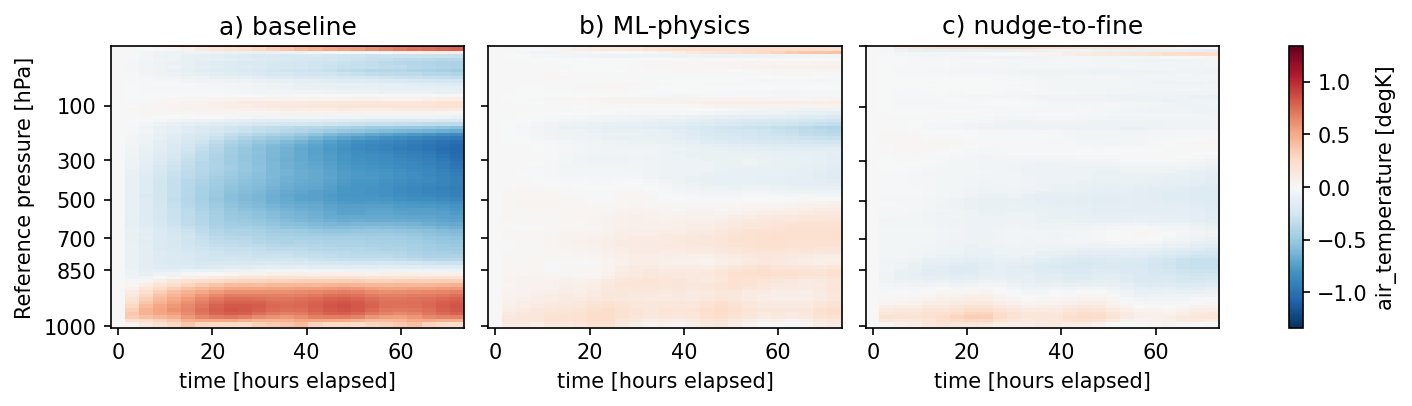

In [18]:
plot_three_panel(error.air_temperature.sel(time=slice(0, 72)), set_xticks=False)

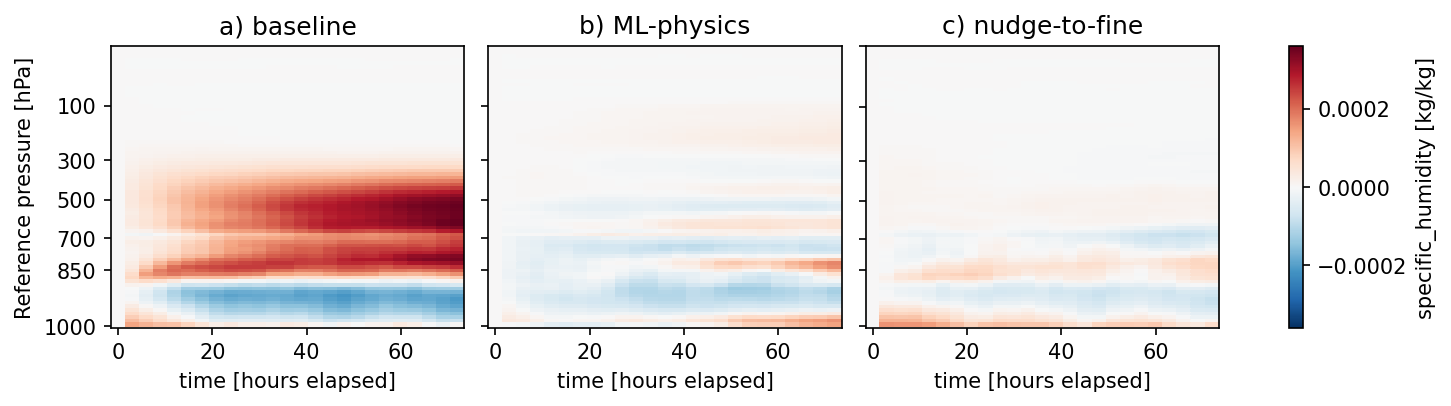

In [19]:
plot_three_panel(error.specific_humidity.sel(time=slice(0, 72)), set_xticks=False)

Showing first 10 days

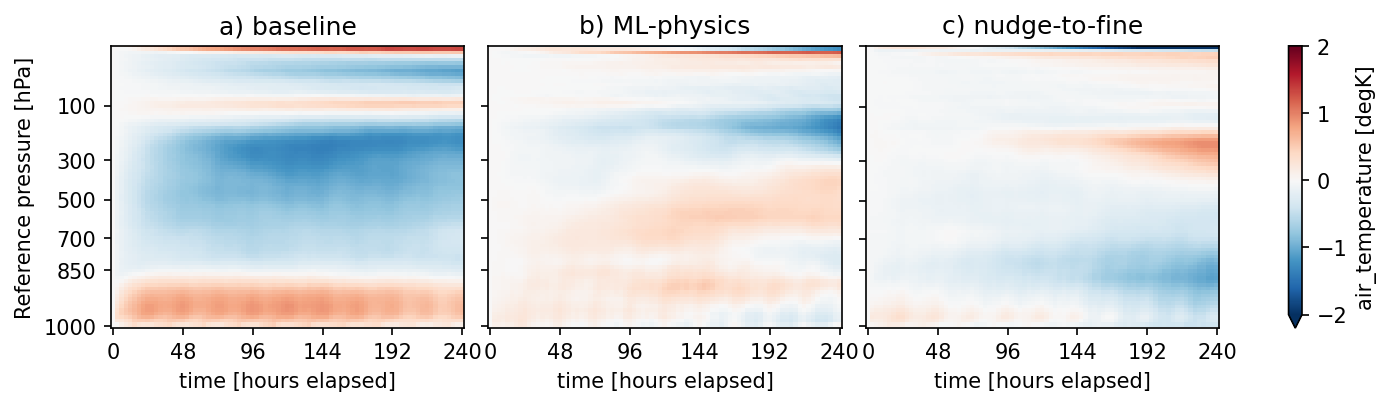

In [20]:
plot_three_panel(error.air_temperature.sel(time=slice(0, 240)), vmin=-2, vmax=2, cmap='RdBu_r')

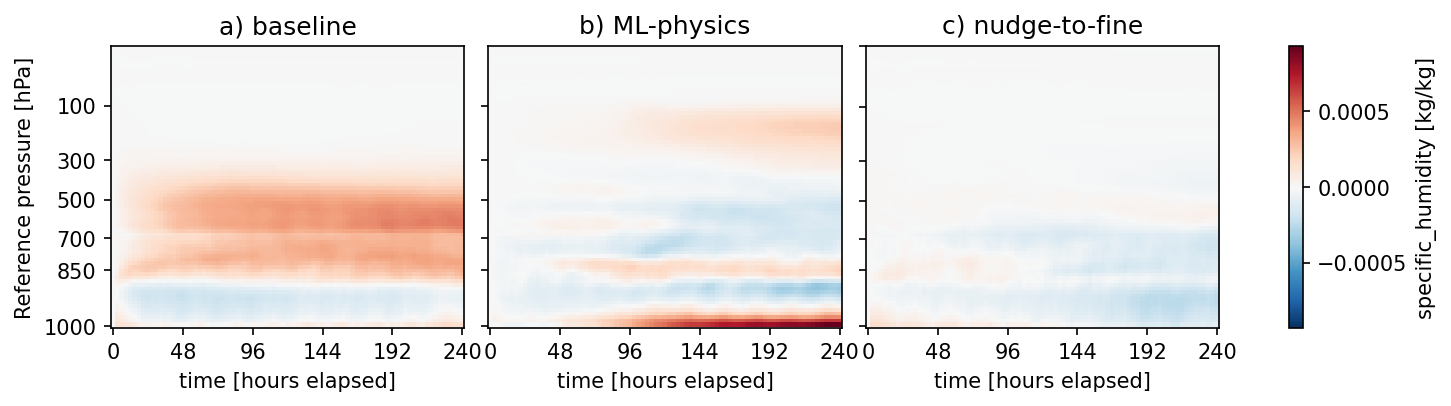

In [21]:
plot_three_panel(error.specific_humidity.sel(time=slice(0, 240)))

### Plot tropical ascent region (5°N - 20°N) mean bias

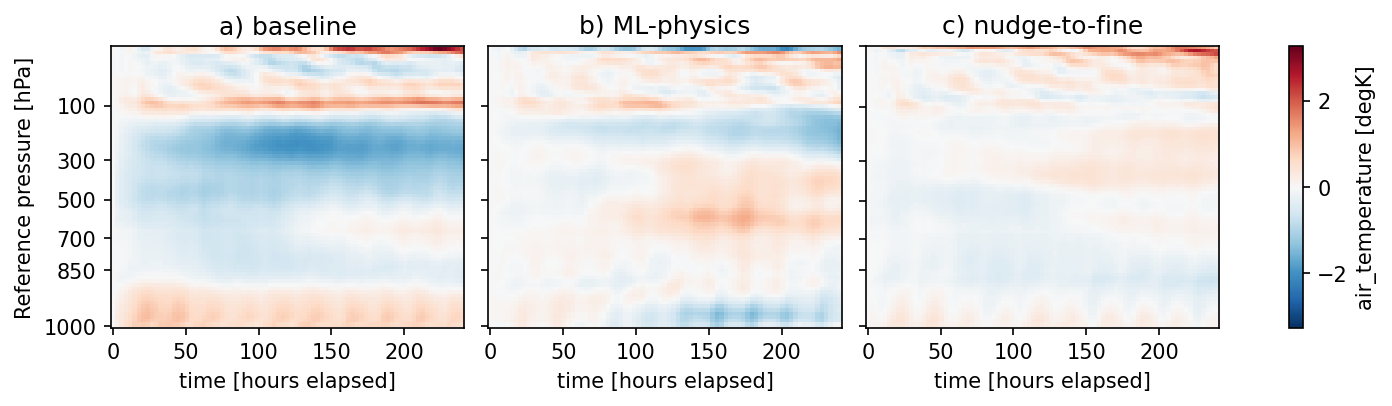

In [22]:
plot_three_panel(ta_error.air_temperature, set_xticks=False)

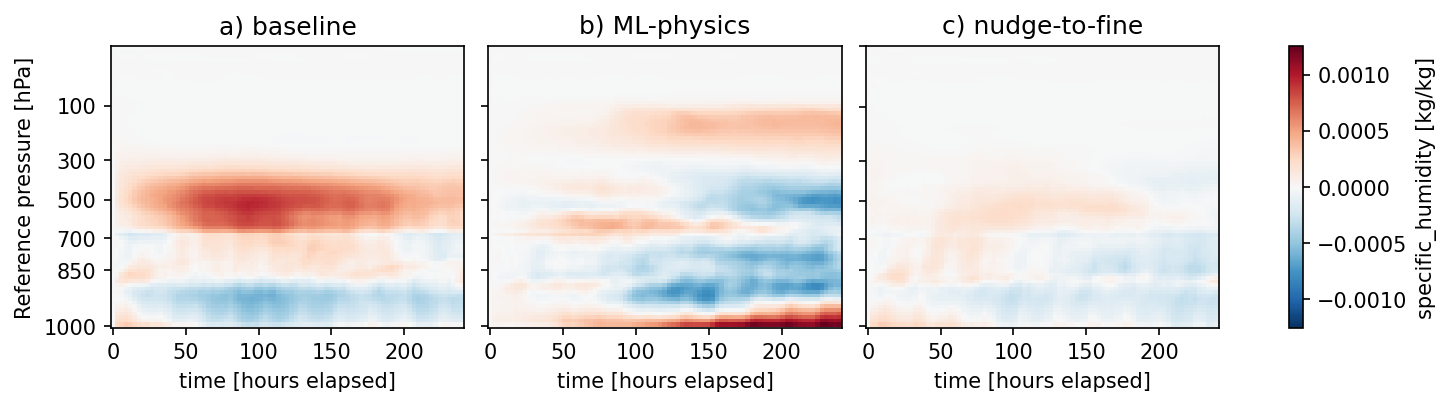

In [23]:
plot_three_panel(ta_error.specific_humidity, set_xticks=False)

### Open pre-computed diagnostics to plot zonal mean biases

In [24]:
urls_long = {
    "baseline": "gs://vcm-ml-experiments/default/2022-11-21/ml-on-fine-baseline-long-trial-0/fv3gfs_run",
    "ML-physics (seed-5)": f"gs://vcm-ml-experiments/default/2022-11-18/ml-on-fine-ensemble-prog-5-long-trial-0/fv3gfs_run",
    "ML-physics (seed-7)": f"gs://vcm-ml-experiments/default/2022-11-18/ml-on-fine-ensemble-prog-7-long-trial-0/fv3gfs_run",
    "nudge-to-fine": "gs://vcm-ml-experiments/default/2022-05-09/ml-on-fine-hybrid-comp-n2f-v3/fv3gfs_run",
}
verif_url = 'gs://vcm-ml-experiments/default/2021-12-16/2020-05-27-40-day-X-SHiELD-simulation-v2/fine-res-budget.zarr'

In [25]:
fs = fsspec.filesystem('gs')
reduced_diags = []
for name, url in urls_long.items():
    tmp = vcm.open_remote_nc(fs, url+'_diagnostics/diags.nc')
    reduced_diags.append(tmp.assign_coords(run=name))
reduced_diags = xr.concat(reduced_diags, dim='run')
reduced_diags = reduced_diags.assign_coords(pressure=reduced_diags.pressure/100)
reduced_diags['pressure'].attrs['units'] = 'hPa'
reduced_diags['specific_humidity_pressure_level_zonal_bias'] = 1000 * reduced_diags['specific_humidity_pressure_level_zonal_bias']
reduced_diags['specific_humidity_pressure_level_zonal_bias'].attrs['units'] = 'g/kg'
reduced_diags['relative_humidity_pressure_level_zonal_bias'] = 100 * reduced_diags['relative_humidity_pressure_level_zonal_bias']
reduced_diags['relative_humidity_pressure_level_zonal_bias'].attrs['units'] = '%'

In [26]:
for variable in ['air_temperature', 'specific_humidity', 'relative_humidity']:
    reduced_diags[f'{variable}_pressure_level_zonal_bias'].attrs['long_name'] = variable.replace('_', ' ') + ' bias'

In [27]:
reduced_diags_only_seed5 = reduced_diags.sel(run=['baseline', 'ML-physics (seed-5)', 'nudge-to-fine'])
reduced_diags_only_seed5 = reduced_diags_only_seed5.assign_coords(run=['baseline', 'ML-physics', 'nudge-to-fine'])

In [28]:
value = 'total_precip_to_surface_zonal_mean_value'
err = 'total_precip_to_surface_zonal_mean_bias'
verif = (reduced_diags[value].isel(run=0) - reduced_diags[err].isel(run=0)).assign_coords(run='fine-res')
hov = xr.concat([reduced_diags[value], verif], dim='run')


In [29]:
def make_nice_labels(fg):
    fg.set_titles(template='{value}')
    fg.axes.flat[0].set_xticks(np.arange(-80, 91, 40))
    fg.axes.flat[0].set_xticklabels(['80S', '40S', 'EQ', '40N', '80N'])
    for letter, ax in zip(string.ascii_lowercase, fg.axes.flat):
        title = ax.get_title()
        ax.set_title(f'{letter}) {title}')
        ax.set_xlabel('')

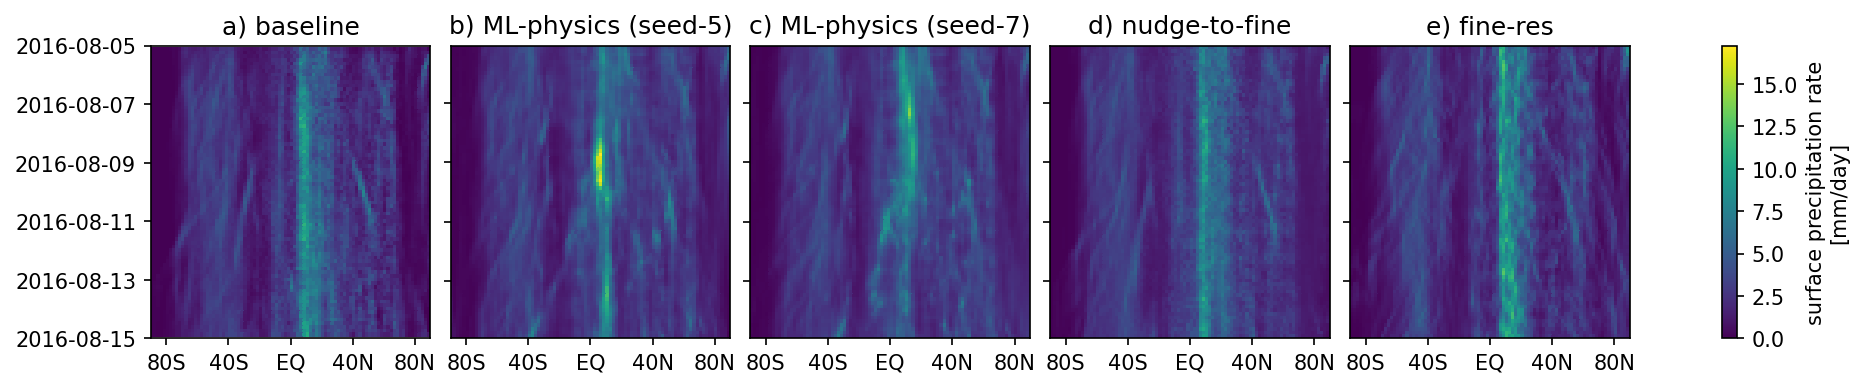

In [30]:
plotme = hov.sel(time=slice('2016-08-05', '2016-08-14T21:00:00'))
plotme.attrs['long_name'] = 'surface precipitation rate'
fg = plotme.plot(col='run', y='time', yincrease=False)
fg.fig.set_size_inches((13.5, 2.8))
fg.axes.flat[0].set_yticks([cftime.datetime(2016,8,d) for d in [5, 7, 9, 11, 13, 15]])
fg.axes.flat[0].set_ylabel('')
make_nice_labels(fg)

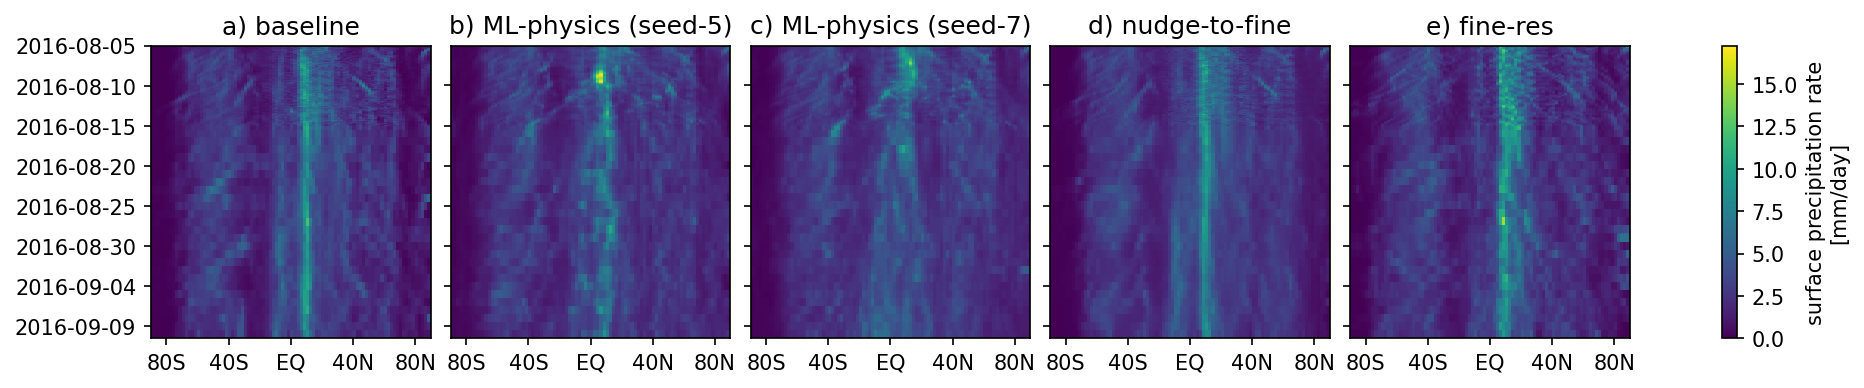

In [31]:
plotme = hov
plotme.attrs['long_name'] = 'surface precipitation rate'
fg = plotme.plot(col='run', y='time', yincrease=False)
fg.fig.set_size_inches((13.5, 2.8))
fg.axes.flat[0].set_yticks([cftime.datetime(2016,8,5) + td for td in [timedelta(days=x) for x in range(0, 36, 5)]])
fg.axes.flat[0].set_ylabel('')
make_nice_labels(fg)

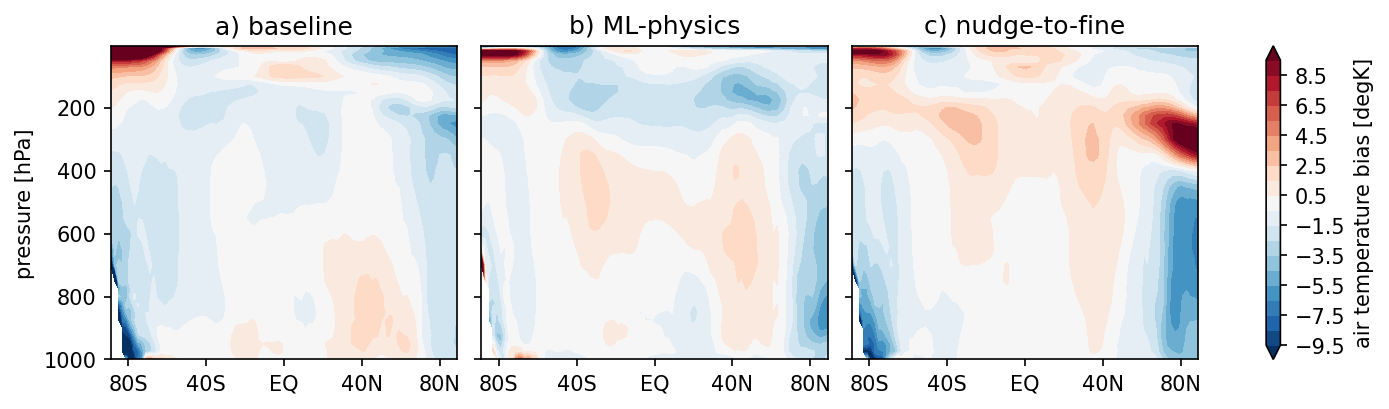

In [32]:
da = reduced_diags_only_seed5.air_temperature_pressure_level_zonal_bias
fg = da.plot.contourf(col='run', y='pressure', yincrease=False, vmin=-9.5, vmax=9.5, levels=20, cmap='RdBu_r')
make_nice_labels(fg)

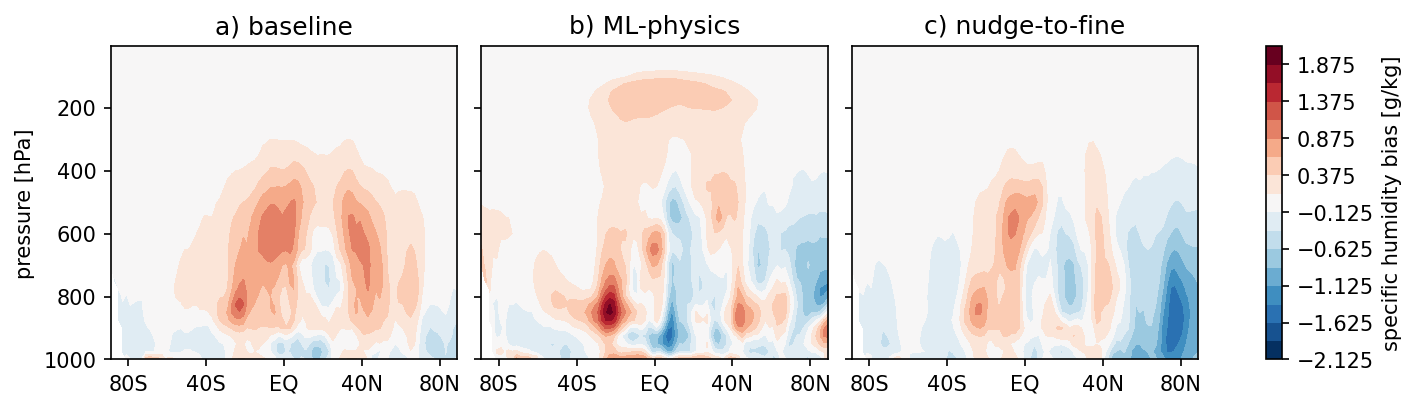

In [33]:
da = reduced_diags_only_seed5.specific_humidity_pressure_level_zonal_bias
fg = da.plot.contourf(col='run', y='pressure', yincrease=False, vmin=-2.125, vmax=2.125, levels=18, cmap='RdBu_r')
make_nice_labels(fg)

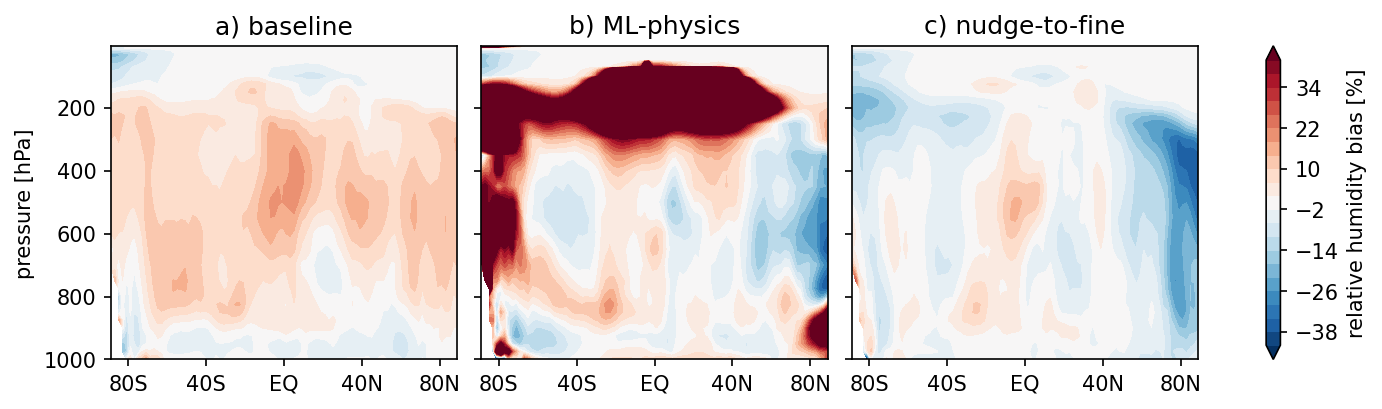

In [34]:
da = reduced_diags_only_seed5.relative_humidity_pressure_level_zonal_bias
fg = da.plot.contourf(col='run', y='pressure', yincrease=False, vmin=-42, vmax=42, levels=22, cmap='RdBu_r', extend='both')
make_nice_labels(fg)

## 